In [32]:
import os
os.chdir('/Users/jjaniak/Documents/studia/projekt/gradient')

import geopandas as gpd
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import shap
import numpy as np

from shapely.wkt import loads

from esda.moran import Moran_Local
import libpysal

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from src.embedders.osm_data_embedder import OSMDataEmbedder
from srai.regionalizers import geocode_to_region_gdf
from srai.embedders import CountEmbedder
from srai.regionalizers import H3Regionalizer
from srai.loaders.osm_loaders.filters import OsmTagsFilter

from IPython.display import display

pd.set_option("display.max_columns", None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [33]:
city_name = "Pozna\u0144"
nominatim_city_name = "Pozna\u0144, Poland"
year = 2022

In [34]:
# Parameters
city_name = "Szczecin"
nominatim_city_name = "Szczecin, Poland"
year = 2022


## Functions

In [35]:
query: OsmTagsFilter = {"highway": True, "railway": True, "route": True}


def create_hex_gds(h3_resolution, city_name=city_name):
    data_embedder = OSMDataEmbedder(
        area=geocode_to_region_gdf(nominatim_city_name),
        embedder=CountEmbedder(),
        regionalizer=H3Regionalizer(resolution=h3_resolution),
        query=query,
    )

    filename = f"data/baseline-datasets/in/{city_name}-hex-res-{h3_resolution}-and-features-gdf.shp"

    if not os.path.exists(filename):
        hex_and_features_gdf = data_embedder.make_embeddings()  # type: ignore
        hex_and_features_gdf.to_file(
            filename,
            index=True,
        )
    else:
        hex_and_features_gdf = gpd.read_file(filename)
        hex_and_features_gdf.set_index("region_id", inplace=True)

    return hex_and_features_gdf


def get_accidents_gdf(h3_resolution, city_name=city_name, year=year):
    filename = f"data/accidents_in_hex/{city_name}_accidents_{year}_res{h3_resolution}.csv"
    if not os.path.exists(filename):
        raise FileNotFoundError(f"The file {filename} does not exist.")
    else:
        accidents_df = pd.read_csv(filename)
        accidents_df['geometry'] = accidents_df['geometry'].apply(loads)
        accidents_gdf = gpd.GeoDataFrame(accidents_df, geometry='geometry', crs="EPSG:4326")
        return accidents_gdf
    
def merge_gdf(accidents_gdf, hex_and_features_gdf):
    merged_gdf = gpd.sjoin(left_df=accidents_gdf, right_df=hex_and_features_gdf, how='inner', op='intersects')
    merged_gdf = merged_gdf.drop(columns='index_right')
    merged_gdf.rename(columns={'count': 'num_accidents'}, inplace=True)
    merged_gdf['num_accidents'] = merged_gdf['num_accidents'].astype(int)

    return merged_gdf

In [36]:
def local_moran(df, column):
    w = libpysal.weights.Queen.from_dataframe(df)
    y = df[column].values
    moran_loc = Moran_Local(y, w)
    return moran_loc.Is, moran_loc.p_sim, moran_loc.q

In [37]:
def correlation_analysis(merged_gdf):
    all_features = merged_gdf.drop(columns=['geometry', 'region_id', 'num_accidents', 'binary_accidents']).columns.to_list()
    
    correlation_matrix = merged_gdf[all_features + ['binary_accidents']].corr()
    correlation_values = correlation_matrix['binary_accidents']

    correlation_metrics = correlation_values.drop('binary_accidents').describe()

    # Calculate the interquartile range (IQR)
    Q1 = correlation_values.drop('binary_accidents').quantile(0.25)
    Q3 = correlation_values.drop('binary_accidents').quantile(0.75)
    IQR = Q3 - Q1

    # Filter features based on IQR
    best_features = correlation_values[(correlation_values < (Q1 - 0.5 * IQR)) | (correlation_values > (Q3 + 0.5 * IQR))].index.to_list()

    best_features.remove('binary_accidents')
    correlation_matrix_best_features = merged_gdf[best_features + ['binary_accidents']].corr()

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix_best_features, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap (best features)')
    plt.show()

    return best_features, correlation_metrics

In [38]:
def shap_analysis(h3_resolution, merged_gdf, selected_features, city_name=city_name, save_force_plot=False):
    y = merged_gdf['binary_accidents']
    X = merged_gdf[selected_features]

    X_train, X_test, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

    linear_lr = LogisticRegression(max_iter=1000)
    linear_lr.fit(X_train, y_train)

    #Przygotowanie przybliżonej próbki tła za pomocą metody k-means.
    background_summary = shap.kmeans(X_train, 10)

    explainer = shap.KernelExplainer(linear_lr.predict_proba, background_summary)

    #Obliczenie SHAP wartości dla danych testowych (X_test), co pozwala na zrozumienie, jak każda zmienna przyczynia się do przewidywanej wartości.
    shap_values = explainer.shap_values(X_test)

    shap.summary_plot(shap_values, X_test)

    if save_force_plot:
        shap.initjs()
        p = shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)
        shap.save_html(f'{city_name}_res_{h3_resolution}_force_plot_best_features.html', p)

## Analysis

Analysis for Resolution = 8
Summary Statistics of Numerical Columns (Sorted by Mean):


,railway__2,railway_ro,railway_ow,railway__1,railway_10,railway__5,railway_ju,highway__1,highway_sp,railway_ha,railway_st,highway_ra,railway_tu,railway__4,highway_pa,highway__3,highway_12,route_ferr,railway__3,highway__6,railway_si,railway_pr,highway_14,highway__8,route_mtb,highway__2,railway_li,railway__6,highway_mi,railway_de,highway_el,railway_pl,highway_10,binary_accidents,railway_cr,highway_gi,highway__4,railway_co,highway_mo,railway_di,railway__9,highway_pl,railway_sw,railway_ab,railway_bu,highway_se,num_accidents,railway_le,railway__7,highway_tu,highway_pe,highway_13,railway_tr,highway_pr,highway_un,railway__8,highway__7,highway_bu,highway_co,highway_li,highway_cy,railway_ra,highway_st,highway_te,highway_tr,highway__5,highway_11,highway_re,highway_cr,highway__9,highway_fo
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000
mean,0.001921,0.001921,0.001921,0.001921,0.001921,0.003568,0.003842,0.005763,0.007684,0.007684,0.009605,0.017289,0.019210,0.019210,0.020307,0.020856,0.021131,0.023052,0.028814,0.030735,0.037047,0.039517,0.040615,0.042261,0.044731,0.051866,0.059550,0.062843,0.079583,0.080681,0.103732,0.121021,0.186334,0.199232,0.230241,0.246981,0.256037,0.262349,0.348244,0.455269,0.489846,0.512898,0.526345,0.588639,0.599890,0.628430,0.655598,0.711306,0.902854,1.043359,1.045554,1.070801,1.237102,1.254116,1.343853,1.440724,1.677003,2.271405,2.611965,3.299396,3.310922,3.463227,4.748902,4.754940,6.102086,6.419868,6.568332,7.686883,10.817783,26.884193,47.864984
std,0.043793,0.043793,0.043793,0.043793,0.043793,0.059630,0.061873,0.075705,0.087332,0.087332,0.097546,0.243449,0.315513,0.315513,0.197776,0.167669,0.143839,0.246893,0.530687,0.289138,0.198815,0.303837,0.672994,0.963440,0.468529,0.254089,0.660662,0.421300,0.291202,0.598809,0.877133,0.542872,0.702624,0.399477,1.205922,1.266529,1.970418,1.406545,1.832925,2.027515,1.768718,1.728036,2.872364,2.652868,2.546124,3.322987,2.250005,3.380699,3.689857,3.071262,4.252478,3.675700,6.809134,4.817011,4.087908,6.051345,4.750221,4.228726,13.687358,10.684664,11.240816,10.851531,13.340936,11.503215,9.541737,12.149241,22.815290,14.379925,26.490522,46.127987,110.753975
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

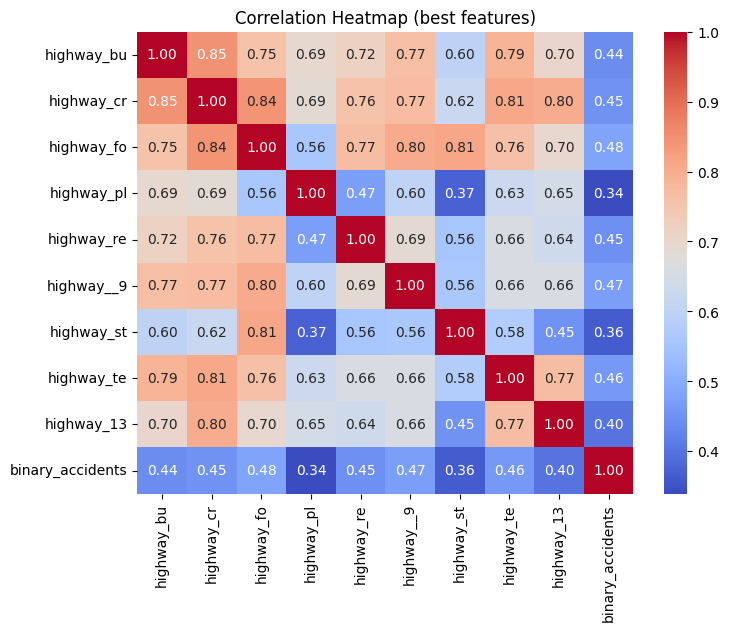

100%|██████████| 729/729 [00:09<00:00, 76.48it/s]


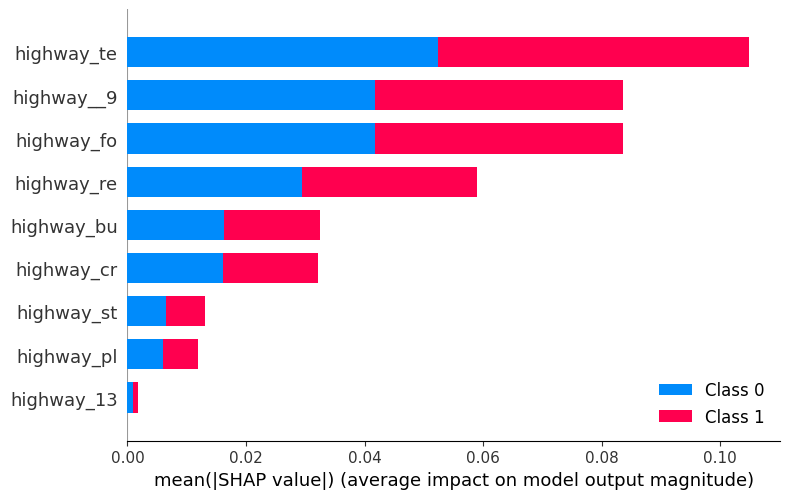

Analysis for Resolution = 9
Summary Statistics of Numerical Columns (Sorted by Mean):


,railway__2,railway_10,railway_ow,railway__5,railway_ju,railway_ro,highway__1,highway_sp,railway_ha,railway_st,railway__1,highway_pa,railway_tu,highway_12,highway__3,highway_ra,railway__3,railway__4,route_ferr,railway_si,highway__6,highway__2,highway_14,highway__8,railway__6,railway_pr,route_mtb,highway_mi,railway_de,railway_li,highway_el,railway_pl,highway_10,railway_cr,highway_gi,highway__4,binary_accidents,railway_co,railway__9,highway_mo,railway_sw,railway_di,highway_pl,railway_bu,num_accidents,railway_le,highway_se,railway__7,highway_tu,railway_ab,highway_13,highway_pe,railway__8,highway_pr,highway_un,railway_tr,highway__7,highway_bu,highway_co,highway_cy,highway_li,highway_st,railway_ra,highway_te,highway_11,highway__5,highway_tr,highway_re,highway_cr,highway__9,highway_fo
count,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.00000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000,23860.000000
mean,0.000293,0.000293,0.000293,0.000503,0.000587,0.000587,0.000880,0.001174,0.001174,0.001467,0.001467,0.003185,0.003227,0.003227,0.003227,0.003814,0.004401,0.004694,0.005574,0.005658,0.006454,0.007921,0.008005,0.008801,0.009514,0.009849,0.010101,0.012196,0.012322,0.012909,0.015842,0.022297,0.028458,0.035583,0.037720,0.046731,0.063537,0.064082,0.074811,0.075608,0.080386,0.088013,0.088894,0.091702,0.100084,0.108801,0.11492,0.137888,0.159723,0.160562,0.164040,0.197988,0.220034,0.235163,0.261148,0.269028,0.333529,0.347737,0.438600,0.593210,0.605826,0.743001,0.849539,0.881433,1.005574,1.237427,1.332188,1.516136,1.656664,4.736756,8.179715
std,0.017126,0.017126,0.017126,0.022421,0.024216,0.024216,0.029655,0.034237,0.034237,0.038273,0.038273,0.070254,0.124657,0.056718,0.061674,0.117366,0.207627,0.125782,0.109535,0.075008,0.125704,0.091900,0.221206,0.303393,0.156564,0.151648,0.162570,0.109763,0.174243,0.282198,0.294266,0.207183,0.220846,0.474629,0.296539,0.626506,0.243932,0.549225,0.447291,0.668475,0.845939,0.690301,0.521810,0.605774,0.575824,0.917840,1.10660,1.018426,0.786328,1.333834,0.938709,1.222693,1.501956,1.405406,1.220001,2.312576,1.470554,1.036365,3.935601,3.170469,2.603841,3.205156,3.716920,3.038912,4.824296,3.066580,2.822071,3.343345,5.235905,9.632276,21.557403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

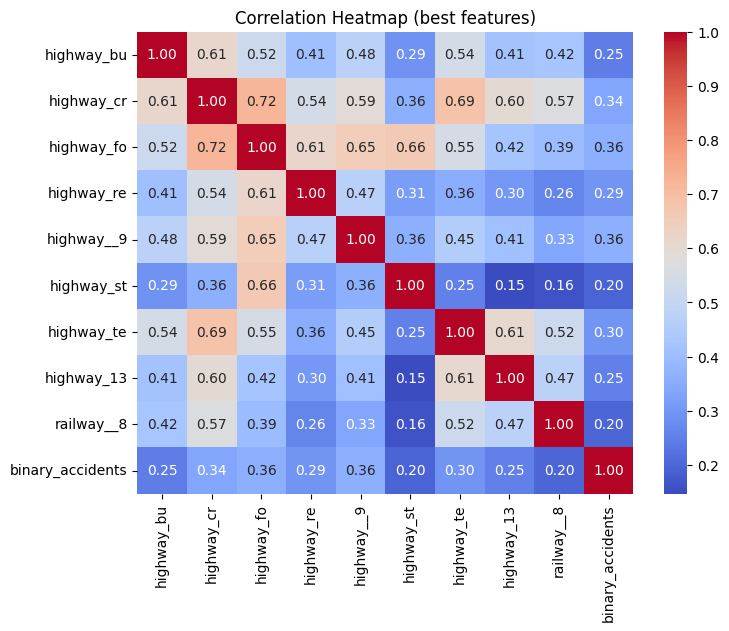

100%|██████████| 4772/4772 [00:59<00:00, 80.03it/s] 


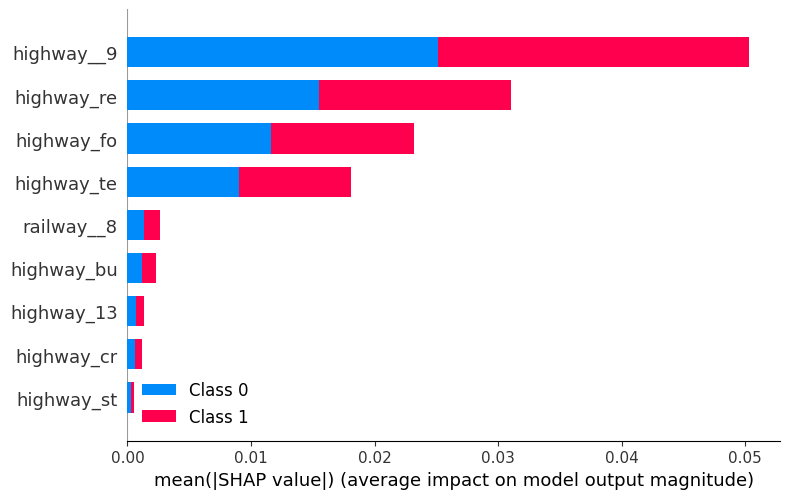

Analysis for Resolution = 10
Summary Statistics of Numerical Columns (Sorted by Mean):


,railway_10,railway_ow,railway__2,railway_ju,railway_ro,railway__5,highway__1,railway_ha,highway_sp,railway_st,highway__3,highway_12,railway_tu,highway_pa,railway__1,railway__3,highway_ra,railway_si,highway__2,railway__4,railway__6,highway__6,highway_mi,railway_de,route_ferr,highway__8,highway_14,highway_el,railway_pr,route_mtb,highway_10,railway_li,railway_cr,highway_gi,railway_pl,highway__4,railway__9,binary_accidents,railway_sw,railway_bu,num_accidents,railway_le,highway_pl,railway_co,railway__7,highway_mo,railway_di,highway_tu,highway_se,highway_13,railway__8,highway_pe,railway_ab,highway_bu,highway_pr,highway_un,railway_tr,highway_co,highway__7,highway_st,highway_cy,highway_li,highway_11,highway_te,highway_cr,railway_ra,highway__5,highway_tr,highway_re,highway__9,highway_fo
count,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.00000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000,162081.000000
mean,0.000043,0.000043,0.000043,0.000086,0.000086,0.000086,0.000173,0.000173,0.000173,0.000216,0.000463,0.000475,0.000475,0.000475,0.000648,0.000648,0.000864,0.001080,0.001166,0.001296,0.001401,0.001641,0.001814,0.001814,0.001857,0.001857,0.001987,0.002332,0.002783,0.003103,0.004189,0.004448,0.005238,0.005565,0.005701,0.010199,0.011013,0.011741,0.011877,0.013543,0.014752,0.016023,0.017923,0.018232,0.020298,0.020453,0.020872,0.023556,0.023772,0.024118,0.032391,0.044354,0.045224,0.051339,0.054047,0.061457,0.07057,0.079207,0.079448,0.112487,0.121982,0.132329,0.148062,0.191861,0.244254,0.258130,0.284796,0.350633,0.361418,0.928770,1.543617
std,0.006572,0.006572,0.006572,0.009294,0.009294,0.009294,0.013142,0.013142,0.013142,0.014693,0.021506,0.021791,0.035387,0.027092,0.025444,0.059868,0.046462,0.032841,0.034128,0.058026,0.057221,0.058017,0.042551,0.058012,0.054558,0.098997,0.079770,0.074894,0.076790,0.075400,0.079024,0.125475,0.176839,0.093896,0.101224,0.199737,0.150176,0.107718,0.222253,0.176991,0.188183,0.266848,0.209429,0.238986,0.309396,0.263449,0.284083,0.206419,0.346070,0.267833,0.437985,0.381473,0.631042,0.310774,0.480137,0.433147,0.78721,1.199424,0.537512,0.739191,0.921637,0.739486,1.079173,0.979292,1.215926,1.481463,0.958395,0.958975,1.000923,2.337234,4.630852
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

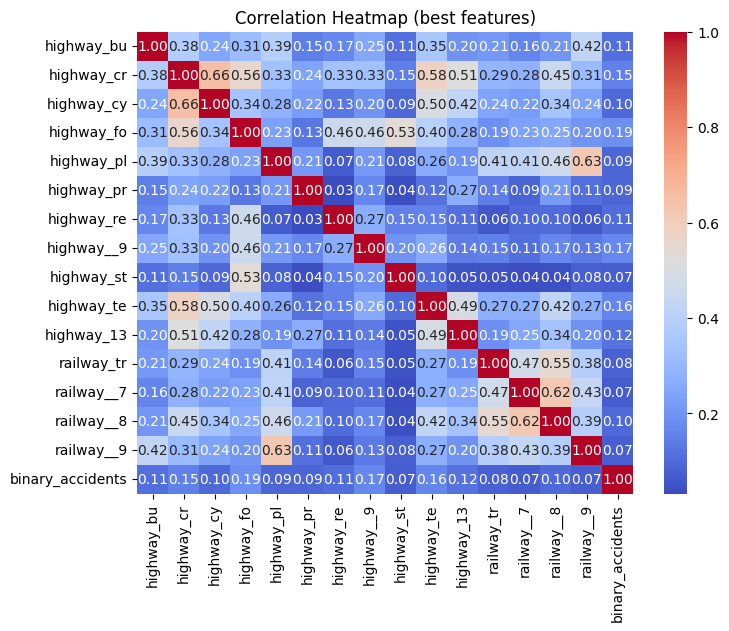

100%|██████████| 32417/32417 [2:18:50<00:00,  3.89it/s]      


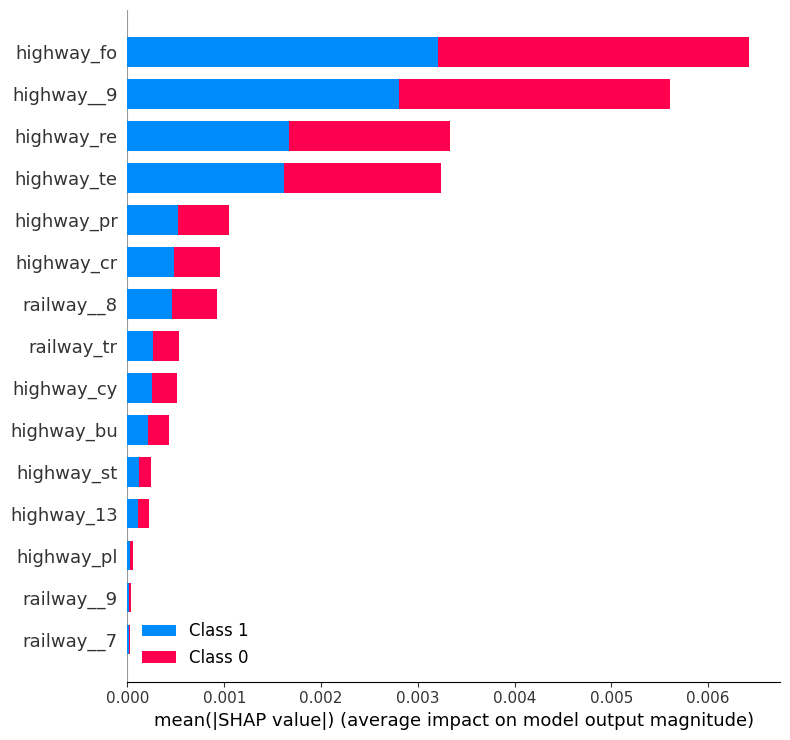

In [39]:
# Set resolutions
resolutions = [8, 9, 10]

# Initialize dataframe and dictionaries to store results
distribution_results = pd.DataFrame(columns=['Resolution', 'Num_Hexes', 'Accidents_Mean', 'Accidents_Std','Binary_Accidents_Mean', 'Binary_Accidents_Std'])
moran_i_results = pd.DataFrame(columns=['Resolution', 'Mean', 'Std', 'Min','Max'])
df_correlation_metrics = pd.DataFrame()

best_features_based_on_correlation = {}
local_moran_results = {} 

# Loop through resolutions
for resolution in resolutions:
    
    print(f"Analysis for Resolution = {resolution}")
    
    # Create hex dataframes
    hex_and_features_gdf = create_hex_gds(h3_resolution=resolution, city_name=city_name)
    accidents_gdf = get_accidents_gdf(h3_resolution=resolution, city_name=city_name, year=year)
    merged_gdf = merge_gdf(accidents_gdf, hex_and_features_gdf)
    
    # Convert accidents count to binary classification
    merged_gdf['binary_accidents'] = 0  # Initialize with 0
    merged_gdf.loc[merged_gdf["num_accidents"] > 0, "binary_accidents"] = 1.0

    new_row = {
        'Resolution': resolution,
        'Num_Hexes': len(merged_gdf),
        'Accidents_Mean': merged_gdf['num_accidents'].mean(),
        'Accidents_Std': merged_gdf['num_accidents'].std(),
        'Binary_Accidents_Mean': merged_gdf['binary_accidents'].mean(),
        'Binary_Accidents_Std': merged_gdf['binary_accidents'].std()
    }
    result_df = pd.DataFrame([new_row], columns=distribution_results.columns)
    distribution_results = pd.concat([distribution_results, result_df], ignore_index=True)
    
    # Summary statistics of numerical columns
    summary_statistics = merged_gdf.describe()
    mean_row = summary_statistics.loc['mean']
    sorted_columns = mean_row.sort_values().index
    summary_statistics_sorted = summary_statistics[sorted_columns]
    print("Summary Statistics of Numerical Columns (Sorted by Mean):")
    display(summary_statistics_sorted)
    
    # Correlation
    best_features, correlation_metrics = correlation_analysis(merged_gdf)
    df_correlation_metrics = pd.concat([df_correlation_metrics, correlation_metrics], axis=1)
    best_features_based_on_correlation[resolution] = best_features
    
    shap_analysis(h3_resolution=resolution, merged_gdf=merged_gdf, selected_features=best_features)
    
    # Calculate Local Moran's I
    moran_i, p_sim, q = local_moran(merged_gdf, column='num_accidents')
    local_moran_results[resolution] = {'moran_i': moran_i, 'p_sim': p_sim, 'q': q}
    new_row = {
        'Resolution': resolution,
        'Mean':  np.mean(moran_i),
        'Std': np.std(moran_i),
        'Min': np.min(moran_i),
        'Max': np.min(moran_i),
    }
    result_df = pd.DataFrame([new_row], columns=distribution_results.columns)
    distribution_results = pd.concat([distribution_results, result_df], ignore_index=True)

Średnia wartość Shapley'a (SHAP) maleje wraz ze wzrostem rozdzielczości. Dla resolution 10 jej wartość dla istotnych na podstawie wcześniejszej analizy korelacji cech, jest poniżej 0.006, więc wybrane cechy mają niewielki wpływ na przewidywania modelu. Natomiast dla najmniejszego resolution równego 8 średnia wartość shap jest ponizej 0.1. 

Cechy, które mozna pominąć na podstawie statystyk (ich liczba jest odwrotnie proporcjonalna do wartości resolution, poniej została wypisana ich suma):	
- railway__1				
- highway_sp		
- railway_ju		
- highway__4					
- railway_st		
- railway_ha		
- highway_12	
- railway_10	
- railway__2
- railway_ro	
- highway__1
- railway_ow	
- railway__5						

Wszystkie z nich wystąpiły tylko raz w heksagonach dla rozdzielczości 8,9, 10. Ich srednia wartość występowania na hexagon jest bliska 0. Żadna z nich nie wykazuje wysokiej korelacji względem binarnej klasyfikacji wypadków.

In [40]:
df_correlation_metrics.columns = [f'resolution={resolution}' for resolution in resolutions]
print("Correlation Metrics of Binary Accidents with All Features:")
display(df_correlation_metrics)

Correlation Metrics of Binary Accidents with All Features:


,resolution=8,resolution=9,resolution=10
count,69.000000,69.000000,69.000000
mean,0.156960,0.080019,0.032924
std,0.142334,0.098081,0.047134
min,-0.023428,-0.025060,-0.020561
25%,0.050526,0.005872,0.000831
50%,0.104543,0.040704,0.011275
75%,0.240441,0.127806,0.043782
max,0.482771,0.362883,0.186623


Średnie wartości korelacji są relatywnie niskie. Najwyższą średnią wartość korelacji osiągnięto dla rozdzielczości 8, co może wskazywać na pewne lokalne zależności. Jednak ogólnie rzecz biorąc, korelacje te są umiarkowane, co sugeruje, że lokalne wzorce przestrzennej korelacji między wypadkami a analizowanymi cechami są zróżnicowane. Wyniki wskazują na mniejszy wpływ lokalnych wzorców przestrzennych na występowanie wypadków drogowych w wyższych rozdzielczościach. Choć korelacja nie jest silna, to jej średnia wartość jest dodatnia, co oznacza, że pewne cechy mogą korelować z występowaniem wypadków drogowych na lokalnym poziomie.

### Rozkład wypadków

In [28]:
print("Distribution of Accidents in Hexes:")
display(distribution_results)

Distribution of Accidents in Hexes:


,Resolution,Num_Hexes,Accidents_Mean,Accidents_Std,Binary_Accidents_Mean,Binary_Accidents_Std
0,8,3644,0.655598,2.250005,0.199232,0.399477
1,9,23860,0.100084,0.575824,0.063537,0.243932
2,10,162081,0.014752,0.188183,0.011741,0.107718


#### Wnioski:

- Wzrastająca rozdzielczość (malejący rozmiar heksagonów) skutkuje spadkiem średniej liczby wypadków na heksagon.
- Odchylenie standardowe liczby wypadków na heksagon jest najwyższe dla rozdzielczości 8, co oznacza większą zmienność w liczbie wypadków między heksagonami w tej rozdzielczości.
- Wartości binarne (czy w danym heksagonie wystąpił przynajmniej jeden wypadek) mają niższe średnie i odchylenia standardowe, co sugeruje, że większość heksagonów nie ma w ogóle wypadków.
- Spadek średniej liczby wypadków na heksagon wraz ze wzrostem rozdzielczości może wynikać z bardziej szczegółowego podziału obszaru, co skutkuje mniejszymi obszarami z mniejszą liczbą wypadków. 
- Większe odchylenie standardowe dla rozdzielczości 8 wskazuje na bardziej zróżnicowane rozkłady liczby wypadków między heksagonami.

### Istotne cechy

In [27]:
print("Best Features Based on Correlation:\n")
for resolution, best_features in best_features_based_on_correlation.items():
    print(f"\nResolution {resolution}:")
    for feature in best_features:
        print(f"{feature}")

Best Features Based on Correlation:


Resolution 8:
highway_bu
highway_cr
highway_fo
highway_pl
highway_re
highway__9
highway_st
highway_te
highway_13

Resolution 9:
highway_bu
highway_cr
highway_fo
highway_re
highway__9
highway_st
highway_te
highway_13
railway__8

Resolution 10:
highway_bu
highway_cr
highway_cy
highway_fo
highway_pl
highway_pr
highway_re
highway__9
highway_st
highway_te
highway_13
railway_tr
railway__7
railway__8
railway__9


In [23]:
features_resolution_8 = best_features_based_on_correlation[8]
features_resolution_9 = best_features_based_on_correlation[9]
features_resolution_10 = best_features_based_on_correlation[10]

# Find common features
common_features = set(features_resolution_8) & set(features_resolution_9) & set(features_resolution_10)

print("Common Features Across All Resolutions:")
for feature in common_features:
    print(feature)


Common Features Across All Resolutions:
highway_st
highway_re
highway_13
highway__9
highway_bu
highway_fo
highway_te
highway_cr


### Moran's I

In [24]:
print("Local Moran's I Results:")
for resolution, results in local_moran_results.items():
    print(f"Resolution {resolution}: Moran's I = {results['moran_i']}, p_sim = {results['p_sim']}, q = {results['q']}")

Local Moran's I Results:
Resolution 8: Moran's I = [0.08490015 0.08490015 0.06165651 ... 0.18216538 0.04719925 0.04327151], p_sim = [0.016 0.001 0.025 ... 0.001 0.258 0.056], q = [3 3 3 ... 1 1 1]
Resolution 9: Moran's I = [0.03020985 0.03020985 0.03020985 ... 0.03020985 0.03020985 0.03020985], p_sim = [0.001 0.034 0.038 ... 0.248 0.059 0.001], q = [3 3 3 ... 3 3 3]
Resolution 10: Moran's I = [0.00614516 0.00614516 0.00614516 ... 0.00614516 0.00614516 0.00614516], p_sim = [0.001 0.001 0.001 ... 0.314 0.314 0.221], q = [3 3 3 ... 3 3 3]


In [30]:
res = {}
for resolution, results in local_moran_results.items():
    res[resolution] = []
    for key, value in results.items():
        res[resolution].extend([np.mean(value), np.std(value), np.min(value), np.max(value)])

local_moran_metrics = list(local_moran_results.values())[0].keys()
id_names = [f'{key}_{stat}' for key in local_moran_metrics for stat in ['mean', 'std', 'min', 'max']]
        
df = pd.DataFrame(res, index=id_names)
df.columns = [f'resolution={resolution}' for resolution in df.columns]
display(df)

,resolution=8,resolution=9,resolution=10
moran_i_mean,0.528101,0.319599,0.189822
moran_i_std,3.535825,4.492784,9.672470
moran_i_min,-0.746060,-1.466441,-1.330343
moran_i_max,63.056471,223.497906,1421.719561
p_sim_mean,0.052975,0.055438,0.009854
p_sim_std,0.105274,0.059044,0.052913
p_sim_min,0.001000,0.001000,0.001000
p_sim_max,0.498000,0.450000,0.395000
q_mean,2.695115,2.718441,2.923785
q_std,0.781277,0.573897,0.306412


#### Wnioski

**moran_i** <br>
Dla rozdzielczości 8 mamy stosunkowo niższe średnie wartości wskaźnika Moran'a I, co może sugerować mniejszą lokalną korelację przestrzenną w porównaniu do rozdzielczości 9 i 10. 
Wartości minimalne i maksymalne wskaźnika Moran'a I dla różnych rozdzielczości wskazują na zróżnicowany charakter lokalnej korelacji przestrzennej. Dla rozdzielczości 8 i 9 wartości maksymalne są relatywnie podobne, ale dla rozdzielczości 10 wartość maksymalna (1421.719561) jest znacząco wyższa, co może wskazywać na obecność obszarów o bardzo silnej lokalnej korelacji przestrzennej.

**p-wartość** <br>
Wartości p_sim są stosunkowo niskie dla wszystkich rozdzielczości, jednak bliskie 0.05, co nie wskazuje jednoznacznie na istotność statystyczną lokalnego wzorca przestrzennej korelacji. Największe wartości p_sim (bliskie 0.4) mogą pochodzić z obszarów o losowym rozkładzie, gdzie brak jest wyraźnych lokalnych wzorców.

**Q** <br>
Średnie wartości Q dla wszystkich rozdzielczości wskazują na to, że istnieją klastry obszarów o podobnych wartościach w sąsiedztwie.  <br>
Maksymalna wartość Q dla rozdzielczości 8 wynosi 4, co sugeruje, że istnieją obszary otoczone przez obszary o podobnych wartościach. Dla rozdzielczości 9 i 10 maksymalna wartość Q wynosi 3, co znaczy, że obszary o wyższych wartościach są bardziej izolowane lub mają bardziej zróżnicowane sąsiedztwo.